In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, Add, MaxPool3D, Dense, GlobalAveragePooling3D
from keras.models import load_model
import nibabel as nib
from scipy import ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_and_preprocess_image(path):
    # load the .nii.gz file
    img = nib.load(path)

    # get the image data and header
    img_data = img.get_fdata()
    img_header = img.header

    # resize the image to (96, 96, 96)
    img_resized = ndimage.zoom(img_data, (96 / img_data.shape[0], 96 / img_data.shape[1], 96 / img_data.shape[2]), order=1)

    # convert the image to an array and normalize it
    img_array = np.asarray(img_resized, dtype=np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    img_array_norm = (img_array - img_min) / (img_max - img_min)

    return img_array_norm

def inception_module(inputs, num_filters):
    # 1x1 convolution branch
    conv1 = tf.keras.layers.Conv3D(num_filters, kernel_size=(1, 1, 1), activation='relu')(inputs)
    
    # 3x3 convolution branch
    conv3 = tf.keras.layers.Conv3D(num_filters, kernel_size=(1, 1, 1), activation='relu')(inputs)
    conv3 = tf.keras.layers.Conv3D(num_filters, kernel_size=(3, 3, 3), padding='same', activation='relu')(conv3)
    
    # # 5x5 convolution branch
    # conv5 = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    # conv5 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, 5), padding='same', activation='relu')(conv5)
    
    # Max pooling branch
    pool = tf.keras.layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(inputs)
    pool = tf.keras.layers.Conv3D(num_filters, kernel_size=(1, 1, 1), activation='relu')(pool)
    
    # Concatenate outputs from all branches
    outputs = tf.keras.layers.concatenate([conv1, conv3, pool], axis=-1)
    
    return outputs

In [ ]:
# Define paths to image directory and label csv file
image_dir = '/content/drive/MyDrive/Abide_Data'
label_file = '/content/drive/MyDrive/B.Tech/abide_label_niigz.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [ ]:
# Define the model architecture
inputs = tf.keras.Input(shape=(96, 96, 96, 1))
x = inception_module(inputs, num_filters=64)
x = inception_module(x, num_filters=128)
x = tf.keras.layers.GlobalAveragePooling3D()(x)
outputs = tf.keras.layers.Dense(units=2, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
opt = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
# Compile the model
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 96, 96, 96,   128         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 96, 96, 96,   0           ['input_1[0][0]']                
                                1)                                                            

In [ ]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_inception_model_abide.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=1, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/20
76/76 [==============================] - 120s 1s/step - loss: 0.6941 - accuracy: 0.5132 - val_loss: 0.6892 - val_accuracy: 0.5500
Epoch 2/20
76/76 [==============================] - 102s 1s/step - loss: 0.6915 - accuracy: 0.5526 - val_loss: 0.6898 - val_accuracy: 0.5500
Epoch 3/20
76/76 [==============================] - 102s 1s/step - loss: 0.6935 - accuracy: 0.5526 - val_loss: 0.6892 - val_accuracy: 0.5500
Epoch 4/20
76/76 [==============================] - 104s 1s/step - loss: 0.6914 - accuracy: 0.5395 - val_loss: 0.6890 - val_accuracy: 0.5500
Epoch 5/20
76/76 [==============================] - 104s 1s/step - loss: 0.6918 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5500
Epoch 6/20
76/76 [==============================] - 101s 1s/step - loss: 0.6920 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5500
Epoch 7/20
76/76 [==============================] - 101s 1s/step - loss: 0.6919 - accuracy: 0.5526 - val_loss: 0.6889 - val_accuracy: 0.5500
Epoch 8/20
76

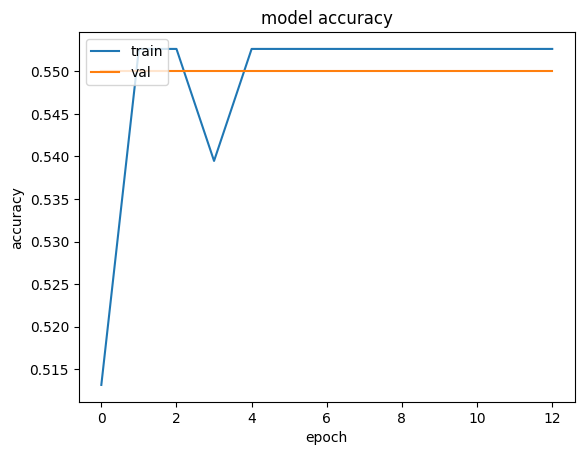

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

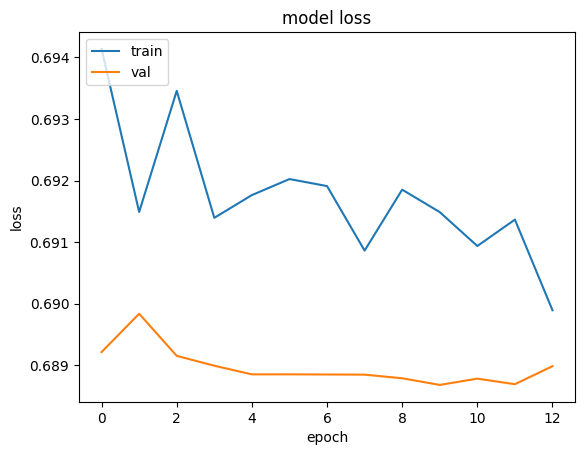

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

ResourceExhaustedError: ignored

In [ ]:
best_model = load_model('best_inception_model_abide.h5')

# Evaluate the model on the testing set
test_loss_b, test_accuracy_b = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss_b)
print('Test accuracy:', test_accuracy_b)

ResourceExhaustedError: ignored

In [ ]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)

ResourceExhaustedError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


In [ ]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

In [ ]:
from sklearn.metrics import classification_report

# Get the classification report
cr = classification_report(y_true, y_pred, digits=4)

print(cr)